In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.nn.functional as F


import torchvision
from torchvision.models import resnet18, ResNet18_Weights, vgg16, VGG16_Weights
from torchvision import datasets
from torchvision import transforms

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


import os
import sys
from torchsummary import summary


#device config
torch.cuda.set_device(1)#Select GPU device 1
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Get Packages
sys.path.append('./Tools')
from AdversarialExamples import GetAdversarialExamples

#Network architectures
from ResNet18_CIFAR10 import ResNet18_CIFAR10_Model
from ResNet18_TINYIMAGENET import ResNet18_TINYIMAGENET_Model
from VGG16_CIFAR10 import VGG16_CIFAR10_Model
from VGG16_TINYIMAGENET import VGG16_TINYIMAGENET_Model

#Non Corrupted DataLoaders
from CIFAR10_LOADER import CIFAR10DataLoader
from TINYIMAGENET_LOADER import TINYIMAGENETDataLoader

#Non Corrupted DataLoaders
from CIFAR10C_LOADER import CIFAR10C_DataLoader #Each Corruption is a entry in the dictionary
from TINYIMAGENET_C_LOADER import TinyImagenetC_DataLoader #Each Corruption is a entry in the dictionary

#Error Metrics
from ErrorMetrics import Evaluate_Model_TOP1


# Unpruned Models / And Original Datasets

In [4]:
#Network weights
ResNet18_CIFAR10_Weights= torch.load("./Networks/ResNet18_CIFAR10_V0.pt")
ResNet18_TINYIMAGENET_Weights=torch.load("./Networks/ResNet18_TINY_IMAGENET_V0.pt")
VGG16_CIFAR10_Weights=torch.load("./Networks/VGG16_CIFAR10_V0.pt")
VGG16_TINYIMAGENET_Weights=torch.load("./Networks/VGG16_TINY_IMAGENET_V0.pt")

#Unpruned Models
ResNet18_CIFAR10_0P=ResNet18_CIFAR10_Model()
ResNet18_CIFAR10_0P.load_state_dict(ResNet18_CIFAR10_Weights)

ResNet18_TINYIMAGENET_0P=ResNet18_TINYIMAGENET_Model()
ResNet18_TINYIMAGENET_0P.load_state_dict(ResNet18_TINYIMAGENET_Weights)

VGG16_CIFAR10_0P=VGG16_CIFAR10_Model()
VGG16_CIFAR10_0P.load_state_dict(VGG16_CIFAR10_Weights)

VGG16_TINYIMAGENET_0P=VGG16_TINYIMAGENET_Model()
VGG16_TINYIMAGENET_0P.load_state_dict(VGG16_TINYIMAGENET_Weights)

#Datasets
from unittest import loader
Times=1
trainloader_CIFAR10, testloader_CIFAR10=CIFAR10DataLoader(batch_size=512*Times) #Load Data for CIFAR10
trainloader_TINYIMAGENET, testloader_TINYIMAGENET=TINYIMAGENETDataLoader(NPZ=True,batch_size=512*Times) #Load Data for TINYIMAGENET
loader_CIFAR10C=CIFAR10C_DataLoader(batch_size=512*Times) #Load Data for CIFAR10C
loader_TinyImagenetC=TinyImagenetC_DataLoader(NPZ=True,batch_size=512*Times) #Load Data for TINYIMAGENETC


#
MeanCIFAR10=(0.491, 0.482, 0.446)
StdCIFAR10=(0.247, 0.243, 0.261)
MeanImagenet=(0.485, 0.456, 0.406)
StdImagenet=(0.229, 0.224, 0.225)

Files already downloaded and verified
Files already downloaded and verified


# Training With Adversarial

In [5]:
def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses, epsilon, mean, std):

    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        data=GetAdversarialExamples(model, data, target, device, epsilon=epsilon, mean=mean, std=std)


        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target) #negative log likelihood loss


        train_losses.append(loss.item())
        loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update).

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        # print statistics
        running_loss += loss.item()
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):

    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified


# Epsilon 0.01

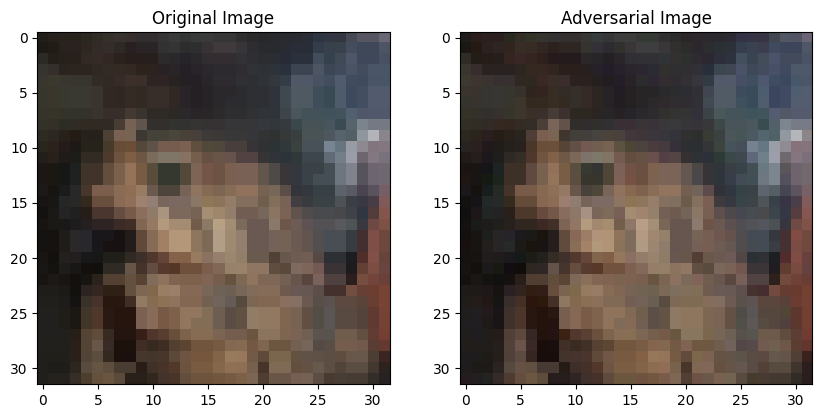

In [37]:
epsilon=0.01 #0.03, 
mean=MeanCIFAR10
std=StdCIFAR10
model=ResNet18_CIFAR10_0P
trainloader=trainloader_CIFAR10
testloader=testloader_CIFAR10



#Check Images for epsion levels
for data, target in trainloader_CIFAR10:
    data, target = data.to(device), target.to(device)
    data_Adv=GetAdversarialExamples(model, data, target, device, epsilon=epsilon, mean=mean, std=std)

    data = transforms.Normalize((-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]), (1/std[0], 1/std[1], 1/std[2]))(data)
    data_Adv = transforms.Normalize((-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]), (1/std[0], 1/std[1], 1/std[2]))(data_Adv)
    break

IdxImage=np.random.randint(0,data.shape[0])
with torch.no_grad():
    #plot an image from data and from data_Adv
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(data[IdxImage].cpu().numpy().transpose(1,2,0))
    plt.title("Original Image")
    plt.subplot(1,2,2)
    plt.imshow(data_Adv[IdxImage].cpu().numpy().transpose(1,2,0))
    plt.title("Adversarial Image")
    plt.show()


In [38]:

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)


train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 100

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses, epsilon, mean, std)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)
    
    if i%10==0:
        torch.save(model.state_dict(), "./Networks/ResNet18_CIFAR10_V0_Adversarial_ep_1p.pt")
        np.savez("./Networks/TrainSteps_ResNet18_CIFAR10_V0_Adversarial_ep_1p.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

torch.save(model.state_dict(), "./Networks/ResNet18_CIFAR10_V0_Adversarial_ep_1p.pt")
np.savez("./Networks/TrainSteps_ResNet18_CIFAR10_V0_Adversarial_ep_1p.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

EPOCHS : 0


Loss=0.9649167656898499 Batch_id=97 Accuracy=62.83: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]



Test set: Average loss: 0.5357, Accuracy: 8212/10000 (82.12%)

EPOCHS : 1


Loss=0.8497330546379089 Batch_id=97 Accuracy=64.27: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]



Test set: Average loss: 0.5511, Accuracy: 8168/10000 (81.68%)

EPOCHS : 2


Loss=0.888983428478241 Batch_id=97 Accuracy=65.07: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s] 



Test set: Average loss: 0.5058, Accuracy: 8279/10000 (82.79%)

EPOCHS : 3


Loss=0.8857955932617188 Batch_id=97 Accuracy=65.93: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 0.5382, Accuracy: 8149/10000 (81.49%)

EPOCHS : 4


Loss=0.9509791135787964 Batch_id=97 Accuracy=66.86: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.



Test set: Average loss: 0.5350, Accuracy: 8179/10000 (81.79%)

EPOCHS : 5


Loss=0.7801470160484314 Batch_id=97 Accuracy=70.14: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s]



Test set: Average loss: 0.4576, Accuracy: 8502/10000 (85.02%)

EPOCHS : 6


Loss=0.817644476890564 Batch_id=97 Accuracy=71.17: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s] 



Test set: Average loss: 0.4494, Accuracy: 8516/10000 (85.16%)

EPOCHS : 7


Loss=0.6905070543289185 Batch_id=97 Accuracy=71.22: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 0.4479, Accuracy: 8510/10000 (85.10%)

EPOCHS : 8


Loss=0.6573983430862427 Batch_id=97 Accuracy=71.75: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 0.4435, Accuracy: 8521/10000 (85.21%)

EPOCHS : 9


Loss=0.7134529948234558 Batch_id=97 Accuracy=71.76: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]



Test set: Average loss: 0.4411, Accuracy: 8502/10000 (85.02%)

EPOCHS : 10


Loss=0.755254864692688 Batch_id=97 Accuracy=71.89: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s] 



Test set: Average loss: 0.4392, Accuracy: 8531/10000 (85.31%)

EPOCHS : 11


Loss=0.7263328433036804 Batch_id=97 Accuracy=72.21: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]

Epoch 00012: reducing learning rate of group 0 to 2.5000e-05.



Test set: Average loss: 0.4348, Accuracy: 8528/10000 (85.28%)

EPOCHS : 12


Loss=0.6658112406730652 Batch_id=97 Accuracy=72.28: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4357, Accuracy: 8537/10000 (85.37%)

EPOCHS : 13


Loss=0.7590907216072083 Batch_id=97 Accuracy=72.54: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]



Test set: Average loss: 0.4356, Accuracy: 8526/10000 (85.26%)

EPOCHS : 14


Loss=0.7664992809295654 Batch_id=97 Accuracy=72.49: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]

Epoch 00015: reducing learning rate of group 0 to 1.2500e-06.



Test set: Average loss: 0.4357, Accuracy: 8521/10000 (85.21%)

EPOCHS : 15


Loss=0.6579541563987732 Batch_id=97 Accuracy=72.45: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]



Test set: Average loss: 0.4356, Accuracy: 8545/10000 (85.45%)

EPOCHS : 16


Loss=0.6869073510169983 Batch_id=97 Accuracy=72.37: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]



Test set: Average loss: 0.4364, Accuracy: 8540/10000 (85.40%)

EPOCHS : 17


Loss=0.767715334892273 Batch_id=97 Accuracy=72.56: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s] 

Epoch 00018: reducing learning rate of group 0 to 6.2500e-08.



Test set: Average loss: 0.4352, Accuracy: 8534/10000 (85.34%)

EPOCHS : 18


Loss=0.7416483163833618 Batch_id=97 Accuracy=72.49: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.4361, Accuracy: 8526/10000 (85.26%)

EPOCHS : 19


Loss=0.669199526309967 Batch_id=97 Accuracy=72.36: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s] 



Test set: Average loss: 0.4354, Accuracy: 8526/10000 (85.26%)

EPOCHS : 20


Loss=0.6605684161186218 Batch_id=97 Accuracy=72.37: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]

Epoch 00021: reducing learning rate of group 0 to 3.1250e-09.



Test set: Average loss: 0.4363, Accuracy: 8518/10000 (85.18%)

EPOCHS : 21


Loss=0.6855761408805847 Batch_id=97 Accuracy=72.43: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4354, Accuracy: 8521/10000 (85.21%)

EPOCHS : 22


Loss=0.8029589653015137 Batch_id=97 Accuracy=72.20: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s]



Test set: Average loss: 0.4359, Accuracy: 8524/10000 (85.24%)

EPOCHS : 23


Loss=0.7010188102722168 Batch_id=97 Accuracy=72.48: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]



Test set: Average loss: 0.4357, Accuracy: 8530/10000 (85.30%)

EPOCHS : 24


Loss=0.7083691358566284 Batch_id=97 Accuracy=72.47: 100%|██████████| 98/98 [00:21<00:00,  4.67it/s]



Test set: Average loss: 0.4356, Accuracy: 8538/10000 (85.38%)

EPOCHS : 25


Loss=0.7354509234428406 Batch_id=97 Accuracy=72.31: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.4361, Accuracy: 8519/10000 (85.19%)

EPOCHS : 26


Loss=0.6500609517097473 Batch_id=97 Accuracy=72.29: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4351, Accuracy: 8533/10000 (85.33%)

EPOCHS : 27


Loss=0.7990019917488098 Batch_id=97 Accuracy=72.52: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4357, Accuracy: 8533/10000 (85.33%)

EPOCHS : 28


Loss=0.7401259541511536 Batch_id=97 Accuracy=72.58: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.4352, Accuracy: 8533/10000 (85.33%)

EPOCHS : 29


Loss=0.7153945565223694 Batch_id=97 Accuracy=72.20: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s]



Test set: Average loss: 0.4354, Accuracy: 8542/10000 (85.42%)

EPOCHS : 30


Loss=0.8877812623977661 Batch_id=97 Accuracy=72.45: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.4352, Accuracy: 8528/10000 (85.28%)

EPOCHS : 31


Loss=0.7223442792892456 Batch_id=97 Accuracy=72.33: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4362, Accuracy: 8525/10000 (85.25%)

EPOCHS : 32


Loss=0.7747929692268372 Batch_id=97 Accuracy=72.17: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s]



Test set: Average loss: 0.4355, Accuracy: 8535/10000 (85.35%)

EPOCHS : 33


Loss=0.7065027952194214 Batch_id=97 Accuracy=72.13: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.4354, Accuracy: 8531/10000 (85.31%)

EPOCHS : 34


Loss=0.6776013374328613 Batch_id=97 Accuracy=72.43: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4357, Accuracy: 8528/10000 (85.28%)

EPOCHS : 35


Loss=0.7271720170974731 Batch_id=97 Accuracy=72.39: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.4350, Accuracy: 8525/10000 (85.25%)

EPOCHS : 36


Loss=0.7243629097938538 Batch_id=97 Accuracy=72.17: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4354, Accuracy: 8534/10000 (85.34%)

EPOCHS : 37


Loss=0.7435420155525208 Batch_id=97 Accuracy=72.44: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4357, Accuracy: 8529/10000 (85.29%)

EPOCHS : 38


Loss=0.8036659955978394 Batch_id=97 Accuracy=72.24: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4349, Accuracy: 8529/10000 (85.29%)

EPOCHS : 39


Loss=0.7705000042915344 Batch_id=97 Accuracy=72.35: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.4344, Accuracy: 8520/10000 (85.20%)

EPOCHS : 40


Loss=0.657879114151001 Batch_id=97 Accuracy=72.35: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s] 



Test set: Average loss: 0.4351, Accuracy: 8532/10000 (85.32%)

EPOCHS : 41


Loss=0.6620316505432129 Batch_id=97 Accuracy=72.35: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.4364, Accuracy: 8525/10000 (85.25%)

EPOCHS : 42


Loss=0.7567691802978516 Batch_id=97 Accuracy=72.24: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4353, Accuracy: 8530/10000 (85.30%)

EPOCHS : 43


Loss=0.7905255556106567 Batch_id=97 Accuracy=72.23: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.4362, Accuracy: 8532/10000 (85.32%)

EPOCHS : 44


Loss=0.7764908671379089 Batch_id=97 Accuracy=72.33: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4355, Accuracy: 8534/10000 (85.34%)

EPOCHS : 45


Loss=0.6639699935913086 Batch_id=97 Accuracy=72.39: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.4363, Accuracy: 8523/10000 (85.23%)

EPOCHS : 46


Loss=0.6842595934867859 Batch_id=97 Accuracy=72.59: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.4356, Accuracy: 8530/10000 (85.30%)

EPOCHS : 47


Loss=0.748680591583252 Batch_id=97 Accuracy=72.26: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s] 



Test set: Average loss: 0.4367, Accuracy: 8518/10000 (85.18%)

EPOCHS : 48


Loss=0.6376904249191284 Batch_id=97 Accuracy=72.62: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.4354, Accuracy: 8535/10000 (85.35%)

EPOCHS : 49


Loss=0.7656672596931458 Batch_id=97 Accuracy=72.25: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4356, Accuracy: 8520/10000 (85.20%)

EPOCHS : 50


Loss=0.7290624976158142 Batch_id=97 Accuracy=72.46: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4355, Accuracy: 8543/10000 (85.43%)

EPOCHS : 51


Loss=0.6884065270423889 Batch_id=97 Accuracy=72.23: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4361, Accuracy: 8516/10000 (85.16%)

EPOCHS : 52


Loss=0.6446974873542786 Batch_id=97 Accuracy=72.48: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]



Test set: Average loss: 0.4359, Accuracy: 8537/10000 (85.37%)

EPOCHS : 53


Loss=0.7542445063591003 Batch_id=97 Accuracy=72.41: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4377, Accuracy: 8527/10000 (85.27%)

EPOCHS : 54


Loss=0.6618729829788208 Batch_id=97 Accuracy=72.32: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.4353, Accuracy: 8524/10000 (85.24%)

EPOCHS : 55


Loss=0.7913896441459656 Batch_id=97 Accuracy=72.36: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4351, Accuracy: 8530/10000 (85.30%)

EPOCHS : 56


Loss=0.6947795152664185 Batch_id=97 Accuracy=72.06: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.4351, Accuracy: 8540/10000 (85.40%)

EPOCHS : 57


Loss=0.8552389740943909 Batch_id=97 Accuracy=72.58: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4351, Accuracy: 8531/10000 (85.31%)

EPOCHS : 58


Loss=0.6927590370178223 Batch_id=97 Accuracy=72.36: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4369, Accuracy: 8509/10000 (85.09%)

EPOCHS : 59


Loss=0.65428626537323 Batch_id=97 Accuracy=72.45: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]  



Test set: Average loss: 0.4372, Accuracy: 8516/10000 (85.16%)

EPOCHS : 60


Loss=0.665647566318512 Batch_id=97 Accuracy=72.29: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s] 



Test set: Average loss: 0.4374, Accuracy: 8523/10000 (85.23%)

EPOCHS : 61


Loss=0.6368594169616699 Batch_id=97 Accuracy=72.23: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.4364, Accuracy: 8518/10000 (85.18%)

EPOCHS : 62


Loss=0.7267597317695618 Batch_id=97 Accuracy=72.31: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4345, Accuracy: 8530/10000 (85.30%)

EPOCHS : 63


Loss=0.7992883324623108 Batch_id=97 Accuracy=72.34: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.4370, Accuracy: 8515/10000 (85.15%)

EPOCHS : 64


Loss=0.7256991267204285 Batch_id=97 Accuracy=72.38: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4363, Accuracy: 8526/10000 (85.26%)

EPOCHS : 65


Loss=0.7716579437255859 Batch_id=97 Accuracy=72.34: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4351, Accuracy: 8537/10000 (85.37%)

EPOCHS : 66


Loss=0.7147337198257446 Batch_id=97 Accuracy=72.26: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4352, Accuracy: 8531/10000 (85.31%)

EPOCHS : 67


Loss=0.6932512521743774 Batch_id=97 Accuracy=72.52: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4364, Accuracy: 8535/10000 (85.35%)

EPOCHS : 68


Loss=0.7832158207893372 Batch_id=97 Accuracy=72.58: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.4365, Accuracy: 8529/10000 (85.29%)

EPOCHS : 69


Loss=0.7265021204948425 Batch_id=97 Accuracy=72.39: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4356, Accuracy: 8538/10000 (85.38%)

EPOCHS : 70


Loss=0.671842098236084 Batch_id=97 Accuracy=72.47: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s] 



Test set: Average loss: 0.4360, Accuracy: 8523/10000 (85.23%)

EPOCHS : 71


Loss=0.6753168702125549 Batch_id=97 Accuracy=72.34: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4351, Accuracy: 8533/10000 (85.33%)

EPOCHS : 72


Loss=0.7016473412513733 Batch_id=97 Accuracy=72.54: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4353, Accuracy: 8536/10000 (85.36%)

EPOCHS : 73


Loss=0.7222933769226074 Batch_id=97 Accuracy=72.39: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4360, Accuracy: 8530/10000 (85.30%)

EPOCHS : 74


Loss=0.6558274030685425 Batch_id=97 Accuracy=72.44: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4363, Accuracy: 8524/10000 (85.24%)

EPOCHS : 75


Loss=0.6688027381896973 Batch_id=97 Accuracy=72.38: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.4369, Accuracy: 8535/10000 (85.35%)

EPOCHS : 76


Loss=0.8041039705276489 Batch_id=97 Accuracy=72.54: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4353, Accuracy: 8530/10000 (85.30%)

EPOCHS : 77


Loss=0.7035378813743591 Batch_id=97 Accuracy=72.43: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.4361, Accuracy: 8527/10000 (85.27%)

EPOCHS : 78


Loss=0.8288846611976624 Batch_id=97 Accuracy=72.56: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.4366, Accuracy: 8525/10000 (85.25%)

EPOCHS : 79


Loss=0.690949559211731 Batch_id=97 Accuracy=72.31: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s] 



Test set: Average loss: 0.4359, Accuracy: 8526/10000 (85.26%)

EPOCHS : 80


Loss=0.6488023996353149 Batch_id=97 Accuracy=72.55: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.4350, Accuracy: 8527/10000 (85.27%)

EPOCHS : 81


Loss=0.7008621096611023 Batch_id=97 Accuracy=72.57: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4349, Accuracy: 8529/10000 (85.29%)

EPOCHS : 82


Loss=0.7223553657531738 Batch_id=97 Accuracy=72.44: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4349, Accuracy: 8534/10000 (85.34%)

EPOCHS : 83


Loss=0.7425304651260376 Batch_id=97 Accuracy=72.41: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]



Test set: Average loss: 0.4366, Accuracy: 8525/10000 (85.25%)

EPOCHS : 84


Loss=0.711143434047699 Batch_id=97 Accuracy=72.48: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s] 



Test set: Average loss: 0.4350, Accuracy: 8538/10000 (85.38%)

EPOCHS : 85


Loss=0.7667841911315918 Batch_id=97 Accuracy=72.41: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4353, Accuracy: 8526/10000 (85.26%)

EPOCHS : 86


Loss=0.7397555112838745 Batch_id=97 Accuracy=72.30: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4350, Accuracy: 8538/10000 (85.38%)

EPOCHS : 87


Loss=0.7420811653137207 Batch_id=97 Accuracy=72.57: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4346, Accuracy: 8529/10000 (85.29%)

EPOCHS : 88


Loss=0.7647072672843933 Batch_id=97 Accuracy=72.41: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.4368, Accuracy: 8521/10000 (85.21%)

EPOCHS : 89


Loss=0.7562928795814514 Batch_id=97 Accuracy=72.36: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4372, Accuracy: 8526/10000 (85.26%)

EPOCHS : 90


Loss=0.7118707895278931 Batch_id=97 Accuracy=72.39: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4350, Accuracy: 8528/10000 (85.28%)

EPOCHS : 91


Loss=0.7778500318527222 Batch_id=97 Accuracy=72.38: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.4359, Accuracy: 8527/10000 (85.27%)

EPOCHS : 92


Loss=0.6902757287025452 Batch_id=97 Accuracy=72.41: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.4363, Accuracy: 8536/10000 (85.36%)

EPOCHS : 93


Loss=0.717842161655426 Batch_id=97 Accuracy=72.43: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s] 



Test set: Average loss: 0.4349, Accuracy: 8545/10000 (85.45%)

EPOCHS : 94


Loss=0.6942083835601807 Batch_id=97 Accuracy=72.44: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4351, Accuracy: 8538/10000 (85.38%)

EPOCHS : 95


Loss=0.753669261932373 Batch_id=97 Accuracy=72.31: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s] 



Test set: Average loss: 0.4354, Accuracy: 8520/10000 (85.20%)

EPOCHS : 96


Loss=0.7161871194839478 Batch_id=97 Accuracy=72.18: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4354, Accuracy: 8536/10000 (85.36%)

EPOCHS : 97


Loss=0.7947815656661987 Batch_id=97 Accuracy=72.11: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4354, Accuracy: 8534/10000 (85.34%)

EPOCHS : 98


Loss=0.7252852916717529 Batch_id=97 Accuracy=72.53: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4366, Accuracy: 8530/10000 (85.30%)

EPOCHS : 99


Loss=0.6625063419342041 Batch_id=97 Accuracy=72.41: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.4362, Accuracy: 8529/10000 (85.29%)



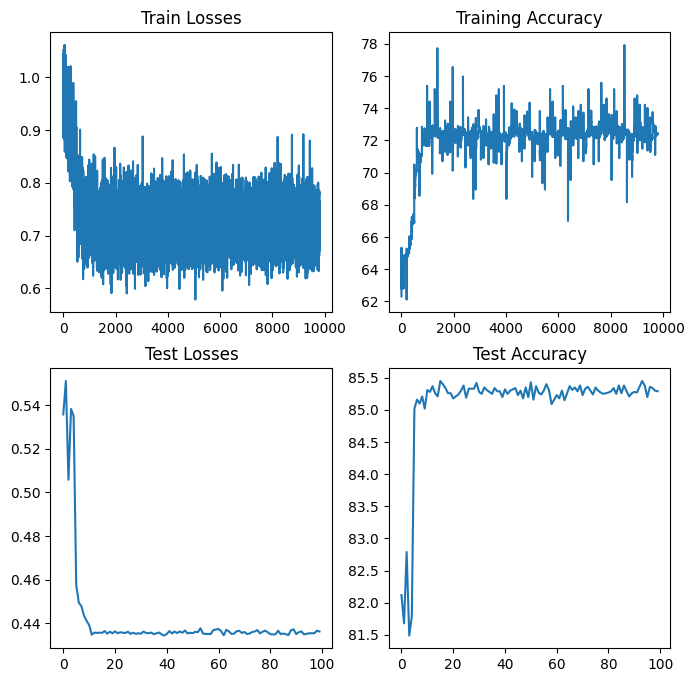

In [39]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)

# Epsilon 0.03

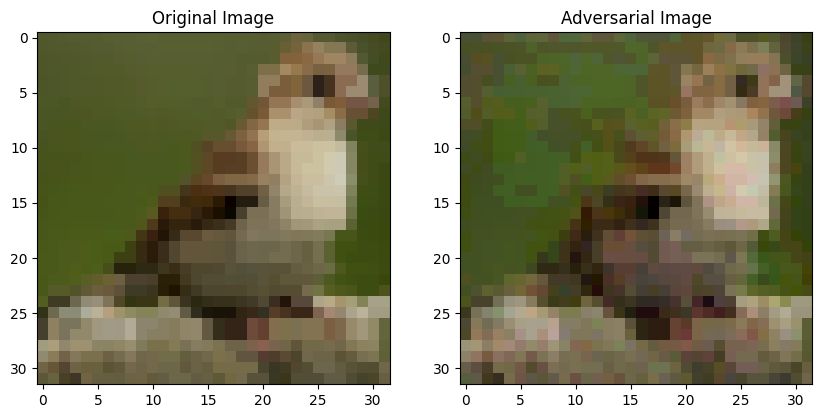

In [43]:
epsilon=0.03 #0.03, 
mean=MeanCIFAR10
std=StdCIFAR10
model=ResNet18_CIFAR10_0P
trainloader=trainloader_CIFAR10
testloader=testloader_CIFAR10



#Check Images for epsion levels
for data, target in trainloader_CIFAR10:
    data, target = data.to(device), target.to(device)
    data_Adv=GetAdversarialExamples(model, data, target, device, epsilon=epsilon, mean=mean, std=std)

    data = transforms.Normalize((-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]), (1/std[0], 1/std[1], 1/std[2]))(data)
    data_Adv = transforms.Normalize((-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]), (1/std[0], 1/std[1], 1/std[2]))(data_Adv)
    break

IdxImage=np.random.randint(0,data.shape[0])
with torch.no_grad():
    #plot an image from data and from data_Adv
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(data[IdxImage].cpu().numpy().transpose(1,2,0))
    plt.title("Original Image")
    plt.subplot(1,2,2)
    plt.imshow(data_Adv[IdxImage].cpu().numpy().transpose(1,2,0))
    plt.title("Adversarial Image")
    plt.show()


In [46]:
epsilon=0.03 #0.03, 
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)


train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 50

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses, epsilon, mean, std)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)
    
    if i%10==0:
        torch.save(model.state_dict(), "./Networks/ResNet18_CIFAR10_V0_Adversarial_ep_3p.pt")
        np.savez("./Networks/TrainSteps_ResNet18_CIFAR10_V0_Adversarial_ep_3p.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

torch.save(model.state_dict(), "./Networks/ResNet18_CIFAR10_V0_Adversarial_ep_3p.pt")
np.savez("./Networks/TrainSteps_ResNet18_CIFAR10_V0_Adversarial_ep_3p.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

EPOCHS : 0


Loss=1.530112624168396 Batch_id=97 Accuracy=37.27: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s] 



Test set: Average loss: 0.8786, Accuracy: 7355/10000 (73.55%)

EPOCHS : 1


Loss=1.4708729982376099 Batch_id=97 Accuracy=41.23: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.8194, Accuracy: 7604/10000 (76.04%)

EPOCHS : 2


Loss=1.5199843645095825 Batch_id=97 Accuracy=42.16: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]



Test set: Average loss: 0.8431, Accuracy: 7564/10000 (75.64%)

EPOCHS : 3


Loss=1.4593061208724976 Batch_id=97 Accuracy=42.86: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]



Test set: Average loss: 0.8301, Accuracy: 7505/10000 (75.05%)

EPOCHS : 4


Loss=1.3373656272888184 Batch_id=97 Accuracy=43.58: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.8380, Accuracy: 7334/10000 (73.34%)

EPOCHS : 5


Loss=1.3928372859954834 Batch_id=97 Accuracy=44.16: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.8346, Accuracy: 7460/10000 (74.60%)

EPOCHS : 6


Loss=1.4731827974319458 Batch_id=97 Accuracy=44.87: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]



Test set: Average loss: 0.8331, Accuracy: 7317/10000 (73.17%)

EPOCHS : 7


Loss=1.3947112560272217 Batch_id=97 Accuracy=45.39: 100%|██████████| 98/98 [00:22<00:00,  4.40it/s]

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.



Test set: Average loss: 0.7964, Accuracy: 7566/10000 (75.66%)

EPOCHS : 8


Loss=1.3283971548080444 Batch_id=97 Accuracy=47.61: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]



Test set: Average loss: 0.7656, Accuracy: 7747/10000 (77.47%)

EPOCHS : 9


Loss=1.292399525642395 Batch_id=97 Accuracy=48.17: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s] 



Test set: Average loss: 0.7613, Accuracy: 7767/10000 (77.67%)

EPOCHS : 10


Loss=1.391047477722168 Batch_id=97 Accuracy=47.99: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s] 



Test set: Average loss: 0.7581, Accuracy: 7739/10000 (77.39%)

EPOCHS : 11


Loss=1.299133539199829 Batch_id=97 Accuracy=48.52: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s] 



Test set: Average loss: 0.7533, Accuracy: 7772/10000 (77.72%)

EPOCHS : 12


Loss=1.3691809177398682 Batch_id=97 Accuracy=48.60: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]

Epoch 00013: reducing learning rate of group 0 to 2.5000e-05.



Test set: Average loss: 0.7525, Accuracy: 7774/10000 (77.74%)

EPOCHS : 13


Loss=1.2800443172454834 Batch_id=97 Accuracy=48.68: 100%|██████████| 98/98 [00:22<00:00,  4.36it/s]



Test set: Average loss: 0.7504, Accuracy: 7768/10000 (77.68%)

EPOCHS : 14


Loss=1.2215741872787476 Batch_id=97 Accuracy=48.48: 100%|██████████| 98/98 [00:21<00:00,  4.66it/s]



Test set: Average loss: 0.7574, Accuracy: 7761/10000 (77.61%)

EPOCHS : 15


Loss=1.2814654111862183 Batch_id=97 Accuracy=48.61: 100%|██████████| 98/98 [00:21<00:00,  4.66it/s]



Test set: Average loss: 0.7445, Accuracy: 7784/10000 (77.84%)

EPOCHS : 16


Loss=1.2989548444747925 Batch_id=97 Accuracy=48.50: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]



Test set: Average loss: 0.7477, Accuracy: 7789/10000 (77.89%)

EPOCHS : 17


Loss=1.3943284749984741 Batch_id=97 Accuracy=48.63: 100%|██████████| 98/98 [00:22<00:00,  4.31it/s]

Epoch 00018: reducing learning rate of group 0 to 1.2500e-06.



Test set: Average loss: 0.7491, Accuracy: 7771/10000 (77.71%)

EPOCHS : 18


Loss=1.3350368738174438 Batch_id=97 Accuracy=48.71: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]



Test set: Average loss: 0.7500, Accuracy: 7778/10000 (77.78%)

EPOCHS : 19


Loss=1.2735830545425415 Batch_id=97 Accuracy=48.83: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]



Test set: Average loss: 0.7510, Accuracy: 7776/10000 (77.76%)

EPOCHS : 20


Loss=1.3103054761886597 Batch_id=97 Accuracy=48.89: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]

Epoch 00021: reducing learning rate of group 0 to 6.2500e-08.



Test set: Average loss: 0.7459, Accuracy: 7789/10000 (77.89%)

EPOCHS : 21


Loss=1.2827587127685547 Batch_id=97 Accuracy=48.82: 100%|██████████| 98/98 [00:22<00:00,  4.37it/s]



Test set: Average loss: 0.7494, Accuracy: 7776/10000 (77.76%)

EPOCHS : 22


Loss=1.2778176069259644 Batch_id=97 Accuracy=48.89: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.7506, Accuracy: 7782/10000 (77.82%)

EPOCHS : 23


Loss=1.2872670888900757 Batch_id=97 Accuracy=48.71: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]

Epoch 00024: reducing learning rate of group 0 to 3.1250e-09.



Test set: Average loss: 0.7480, Accuracy: 7774/10000 (77.74%)

EPOCHS : 24


Loss=1.286801815032959 Batch_id=97 Accuracy=48.67: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s] 



Test set: Average loss: 0.7534, Accuracy: 7756/10000 (77.56%)

EPOCHS : 25


Loss=1.3400382995605469 Batch_id=97 Accuracy=48.51: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]



Test set: Average loss: 0.7505, Accuracy: 7783/10000 (77.83%)

EPOCHS : 26


Loss=1.3396815061569214 Batch_id=97 Accuracy=48.67: 100%|██████████| 98/98 [00:21<00:00,  4.66it/s]



Test set: Average loss: 0.7502, Accuracy: 7774/10000 (77.74%)

EPOCHS : 27


Loss=1.3013880252838135 Batch_id=97 Accuracy=48.82: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]



Test set: Average loss: 0.7522, Accuracy: 7766/10000 (77.66%)

EPOCHS : 28


Loss=1.2842803001403809 Batch_id=97 Accuracy=48.84: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.7513, Accuracy: 7779/10000 (77.79%)

EPOCHS : 29


Loss=1.3536077737808228 Batch_id=97 Accuracy=48.51: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]



Test set: Average loss: 0.7465, Accuracy: 7795/10000 (77.95%)

EPOCHS : 30


Loss=1.353592872619629 Batch_id=97 Accuracy=48.82: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s] 



Test set: Average loss: 0.7510, Accuracy: 7785/10000 (77.85%)

EPOCHS : 31


Loss=1.3517215251922607 Batch_id=97 Accuracy=48.62: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]



Test set: Average loss: 0.7521, Accuracy: 7786/10000 (77.86%)

EPOCHS : 32


Loss=1.319822907447815 Batch_id=97 Accuracy=48.82: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s] 



Test set: Average loss: 0.7485, Accuracy: 7778/10000 (77.78%)

EPOCHS : 33


Loss=1.2892061471939087 Batch_id=97 Accuracy=48.78: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]



Test set: Average loss: 0.7491, Accuracy: 7768/10000 (77.68%)

EPOCHS : 34


Loss=1.317007303237915 Batch_id=97 Accuracy=48.83: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s] 



Test set: Average loss: 0.7477, Accuracy: 7790/10000 (77.90%)

EPOCHS : 35


Loss=1.2564606666564941 Batch_id=97 Accuracy=48.97: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]



Test set: Average loss: 0.7468, Accuracy: 7791/10000 (77.91%)

EPOCHS : 36


Loss=1.2794767618179321 Batch_id=97 Accuracy=48.78: 100%|██████████| 98/98 [00:28<00:00,  3.43it/s]



Test set: Average loss: 0.7524, Accuracy: 7784/10000 (77.84%)

EPOCHS : 37


Loss=1.3294305801391602 Batch_id=97 Accuracy=48.58: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]



Test set: Average loss: 0.7494, Accuracy: 7787/10000 (77.87%)

EPOCHS : 38


Loss=1.3453242778778076 Batch_id=97 Accuracy=48.73: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.7491, Accuracy: 7775/10000 (77.75%)

EPOCHS : 39


Loss=1.3380663394927979 Batch_id=97 Accuracy=48.87: 100%|██████████| 98/98 [00:33<00:00,  2.94it/s]



Test set: Average loss: 0.7496, Accuracy: 7766/10000 (77.66%)

EPOCHS : 40


Loss=1.321041464805603 Batch_id=97 Accuracy=48.72: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s] 



Test set: Average loss: 0.7467, Accuracy: 7798/10000 (77.98%)

EPOCHS : 41


Loss=1.3143926858901978 Batch_id=97 Accuracy=48.65: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]



Test set: Average loss: 0.7468, Accuracy: 7782/10000 (77.82%)

EPOCHS : 42


Loss=1.27535879611969 Batch_id=97 Accuracy=48.73: 100%|██████████| 98/98 [00:33<00:00,  2.96it/s]  



Test set: Average loss: 0.7512, Accuracy: 7776/10000 (77.76%)

EPOCHS : 43


Loss=1.3971413373947144 Batch_id=97 Accuracy=48.73: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s]



Test set: Average loss: 0.7529, Accuracy: 7767/10000 (77.67%)

EPOCHS : 44


Loss=1.2087297439575195 Batch_id=97 Accuracy=48.98: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]



Test set: Average loss: 0.7490, Accuracy: 7787/10000 (77.87%)

EPOCHS : 45


Loss=1.2792203426361084 Batch_id=97 Accuracy=48.79: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]



Test set: Average loss: 0.7535, Accuracy: 7774/10000 (77.74%)

EPOCHS : 46


Loss=1.3284337520599365 Batch_id=97 Accuracy=48.70: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]



Test set: Average loss: 0.7498, Accuracy: 7790/10000 (77.90%)

EPOCHS : 47


Loss=1.3217909336090088 Batch_id=97 Accuracy=48.77: 100%|██████████| 98/98 [00:34<00:00,  2.83it/s]



Test set: Average loss: 0.7543, Accuracy: 7758/10000 (77.58%)

EPOCHS : 48


Loss=1.2959758043289185 Batch_id=97 Accuracy=48.56: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]



Test set: Average loss: 0.7518, Accuracy: 7768/10000 (77.68%)

EPOCHS : 49


Loss=1.2846672534942627 Batch_id=97 Accuracy=48.75: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]



Test set: Average loss: 0.7499, Accuracy: 7780/10000 (77.80%)



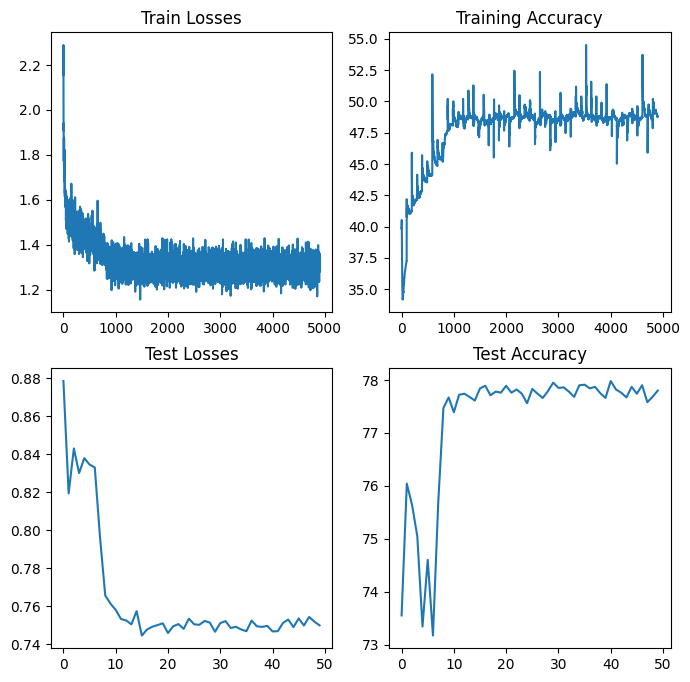

In [47]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)

# Epsilon 0.005

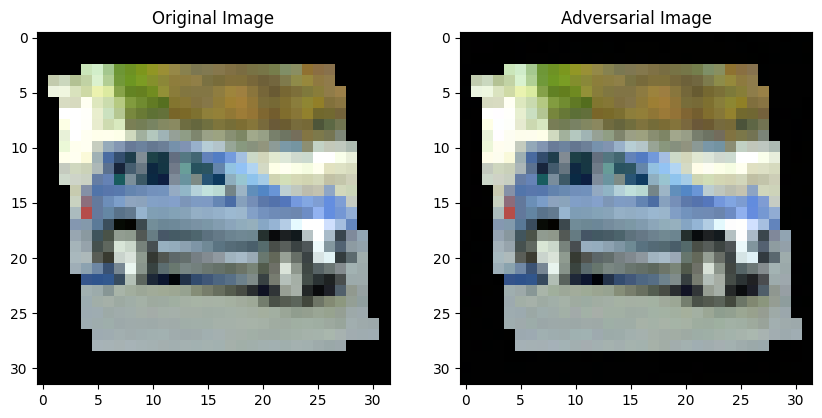

In [44]:
epsilon=0.005 #0.03, 
mean=MeanCIFAR10
std=StdCIFAR10
model=ResNet18_CIFAR10_0P
trainloader=trainloader_CIFAR10
testloader=testloader_CIFAR10



#Check Images for epsion levels
for data, target in trainloader_CIFAR10:
    data, target = data.to(device), target.to(device)
    data_Adv=GetAdversarialExamples(model, data, target, device, epsilon=epsilon, mean=mean, std=std)

    data = transforms.Normalize((-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]), (1/std[0], 1/std[1], 1/std[2]))(data)
    data_Adv = transforms.Normalize((-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]), (1/std[0], 1/std[1], 1/std[2]))(data_Adv)
    break

IdxImage=np.random.randint(0,data.shape[0])
with torch.no_grad():
    #plot an image from data and from data_Adv
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(data[IdxImage].cpu().numpy().transpose(1,2,0))
    plt.title("Original Image")
    plt.subplot(1,2,2)
    plt.imshow(data_Adv[IdxImage].cpu().numpy().transpose(1,2,0))
    plt.title("Adversarial Image")
    plt.show()


In [48]:

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

epsilon=0.005 #0.03, 
train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 50

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses, epsilon, mean, std)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)
    
    if i%10==0:
        torch.save(model.state_dict(), "./Networks/ResNet18_CIFAR10_V0_Adversarial_ep_05p.pt")
        np.savez("./Networks/TrainSteps_ResNet18_CIFAR10_V0_Adversarial_ep_05p.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

torch.save(model.state_dict(), "./Networks/ResNet18_CIFAR10_V0_Adversarial_ep_05p.pt")
np.savez("./Networks/TrainSteps_ResNet18_CIFAR10_V0_Adversarial_ep_05p.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

EPOCHS : 0


Loss=0.5206338167190552 Batch_id=97 Accuracy=78.83: 100%|██████████| 98/98 [00:32<00:00,  2.97it/s] 



Test set: Average loss: 0.4682, Accuracy: 8367/10000 (83.67%)

EPOCHS : 1


Loss=0.5744730830192566 Batch_id=97 Accuracy=80.99: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s] 



Test set: Average loss: 0.4307, Accuracy: 8462/10000 (84.62%)

EPOCHS : 2


Loss=0.4557390809059143 Batch_id=97 Accuracy=81.88: 100%|██████████| 98/98 [00:32<00:00,  2.97it/s] 



Test set: Average loss: 0.4293, Accuracy: 8510/10000 (85.10%)

EPOCHS : 3


Loss=0.5971125960350037 Batch_id=97 Accuracy=82.40: 100%|██████████| 98/98 [00:33<00:00,  2.94it/s] 



Test set: Average loss: 0.4387, Accuracy: 8484/10000 (84.84%)

EPOCHS : 4


Loss=0.45865797996520996 Batch_id=97 Accuracy=82.89: 100%|██████████| 98/98 [00:33<00:00,  2.96it/s]



Test set: Average loss: 0.5436, Accuracy: 8142/10000 (81.42%)

EPOCHS : 5


Loss=0.44556286931037903 Batch_id=97 Accuracy=83.62: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]



Test set: Average loss: 0.4166, Accuracy: 8605/10000 (86.05%)

EPOCHS : 6


Loss=0.4482995867729187 Batch_id=97 Accuracy=84.18: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s] 



Test set: Average loss: 0.4567, Accuracy: 8505/10000 (85.05%)

EPOCHS : 7


Loss=0.4230034351348877 Batch_id=97 Accuracy=84.32: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s] 



Test set: Average loss: 0.4497, Accuracy: 8488/10000 (84.88%)

EPOCHS : 8


Loss=0.3663990795612335 Batch_id=97 Accuracy=85.12: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s] 



Test set: Average loss: 0.4374, Accuracy: 8542/10000 (85.42%)

EPOCHS : 9


Loss=0.320508748292923 Batch_id=97 Accuracy=85.54: 100%|██████████| 98/98 [00:33<00:00,  2.96it/s]  



Test set: Average loss: 0.4783, Accuracy: 8467/10000 (84.67%)

EPOCHS : 10


Loss=0.36879411339759827 Batch_id=97 Accuracy=85.66: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]



Test set: Average loss: 0.4186, Accuracy: 8614/10000 (86.14%)

EPOCHS : 11


Loss=0.37117892503738403 Batch_id=97 Accuracy=86.25: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]



Test set: Average loss: 0.4847, Accuracy: 8454/10000 (84.54%)

EPOCHS : 12


Loss=0.38261890411376953 Batch_id=97 Accuracy=86.75: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]

Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.



Test set: Average loss: 0.4472, Accuracy: 8521/10000 (85.21%)

EPOCHS : 13


Loss=0.2580462098121643 Batch_id=97 Accuracy=90.31: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s] 



Test set: Average loss: 0.3711, Accuracy: 8737/10000 (87.37%)

EPOCHS : 14


Loss=0.24055016040802002 Batch_id=97 Accuracy=91.51: 100%|██████████| 98/98 [00:32<00:00,  2.97it/s]



Test set: Average loss: 0.3660, Accuracy: 8775/10000 (87.75%)

EPOCHS : 15


Loss=0.2711464464664459 Batch_id=97 Accuracy=91.94: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s] 



Test set: Average loss: 0.3627, Accuracy: 8803/10000 (88.03%)

EPOCHS : 16


Loss=0.2498559057712555 Batch_id=97 Accuracy=92.14: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s] 



Test set: Average loss: 0.3601, Accuracy: 8818/10000 (88.18%)

EPOCHS : 17


Loss=0.22418612241744995 Batch_id=97 Accuracy=92.48: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.3597, Accuracy: 8816/10000 (88.16%)

EPOCHS : 18


Loss=0.17576462030410767 Batch_id=97 Accuracy=92.68: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]



Test set: Average loss: 0.3599, Accuracy: 8819/10000 (88.19%)

EPOCHS : 19


Loss=0.23417261242866516 Batch_id=97 Accuracy=92.78: 100%|██████████| 98/98 [00:31<00:00,  3.08it/s]



Test set: Average loss: 0.3598, Accuracy: 8813/10000 (88.13%)

EPOCHS : 20


Loss=0.22139397263526917 Batch_id=97 Accuracy=93.02: 100%|██████████| 98/98 [00:33<00:00,  2.96it/s]



Test set: Average loss: 0.3602, Accuracy: 8802/10000 (88.02%)

EPOCHS : 21


Loss=0.21674780547618866 Batch_id=97 Accuracy=93.05: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s]

Epoch 00022: reducing learning rate of group 0 to 2.5000e-05.



Test set: Average loss: 0.3619, Accuracy: 8809/10000 (88.09%)

EPOCHS : 22


Loss=0.192927747964859 Batch_id=97 Accuracy=93.02: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s]  



Test set: Average loss: 0.3612, Accuracy: 8816/10000 (88.16%)

EPOCHS : 23


Loss=0.1601702868938446 Batch_id=97 Accuracy=93.10: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s] 



Test set: Average loss: 0.3590, Accuracy: 8823/10000 (88.23%)

EPOCHS : 24


Loss=0.25435003638267517 Batch_id=97 Accuracy=93.30: 100%|██████████| 98/98 [00:33<00:00,  2.94it/s]



Test set: Average loss: 0.3596, Accuracy: 8823/10000 (88.23%)

EPOCHS : 25


Loss=0.16873930394649506 Batch_id=97 Accuracy=93.12: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.3597, Accuracy: 8831/10000 (88.31%)

EPOCHS : 26


Loss=0.1983916014432907 Batch_id=97 Accuracy=93.22: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s] 

Epoch 00027: reducing learning rate of group 0 to 1.2500e-06.



Test set: Average loss: 0.3589, Accuracy: 8827/10000 (88.27%)

EPOCHS : 27


Loss=0.18213680386543274 Batch_id=97 Accuracy=93.37: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]



Test set: Average loss: 0.3612, Accuracy: 8817/10000 (88.17%)

EPOCHS : 28


Loss=0.1686183214187622 Batch_id=97 Accuracy=93.08: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s] 



Test set: Average loss: 0.3598, Accuracy: 8814/10000 (88.14%)

EPOCHS : 29


Loss=0.25261393189430237 Batch_id=97 Accuracy=93.22: 100%|██████████| 98/98 [00:33<00:00,  2.95it/s]

Epoch 00030: reducing learning rate of group 0 to 6.2500e-08.



Test set: Average loss: 0.3599, Accuracy: 8820/10000 (88.20%)

EPOCHS : 30


Loss=0.20366331934928894 Batch_id=97 Accuracy=93.32: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.3604, Accuracy: 8817/10000 (88.17%)

EPOCHS : 31


Loss=0.19223597645759583 Batch_id=97 Accuracy=93.35: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s]



Test set: Average loss: 0.3612, Accuracy: 8820/10000 (88.20%)

EPOCHS : 32


Loss=0.21218326687812805 Batch_id=97 Accuracy=93.44: 100%|██████████| 98/98 [00:32<00:00,  2.97it/s]

Epoch 00033: reducing learning rate of group 0 to 3.1250e-09.



Test set: Average loss: 0.3623, Accuracy: 8817/10000 (88.17%)

EPOCHS : 33


Loss=0.16893427073955536 Batch_id=97 Accuracy=93.17: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s]



Test set: Average loss: 0.3608, Accuracy: 8819/10000 (88.19%)

EPOCHS : 34


Loss=0.21177521347999573 Batch_id=97 Accuracy=93.28: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]



Test set: Average loss: 0.3599, Accuracy: 8815/10000 (88.15%)

EPOCHS : 35


Loss=0.27075812220573425 Batch_id=97 Accuracy=93.29: 100%|██████████| 98/98 [00:35<00:00,  2.78it/s]



Test set: Average loss: 0.3614, Accuracy: 8813/10000 (88.13%)

EPOCHS : 36


Loss=0.20910237729549408 Batch_id=97 Accuracy=93.21: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.3601, Accuracy: 8815/10000 (88.15%)

EPOCHS : 37


Loss=0.17966224253177643 Batch_id=97 Accuracy=93.32: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]



Test set: Average loss: 0.3606, Accuracy: 8819/10000 (88.19%)

EPOCHS : 38


Loss=0.20450301468372345 Batch_id=97 Accuracy=93.32: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.3606, Accuracy: 8817/10000 (88.17%)

EPOCHS : 39


Loss=0.191112220287323 Batch_id=97 Accuracy=93.28: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]  



Test set: Average loss: 0.3594, Accuracy: 8825/10000 (88.25%)

EPOCHS : 40


Loss=0.15998628735542297 Batch_id=97 Accuracy=93.26: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]



Test set: Average loss: 0.3607, Accuracy: 8826/10000 (88.26%)

EPOCHS : 41


Loss=0.19958913326263428 Batch_id=97 Accuracy=93.17: 100%|██████████| 98/98 [00:33<00:00,  2.96it/s]



Test set: Average loss: 0.3601, Accuracy: 8822/10000 (88.22%)

EPOCHS : 42


Loss=0.24616897106170654 Batch_id=97 Accuracy=93.27: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]



Test set: Average loss: 0.3598, Accuracy: 8815/10000 (88.15%)

EPOCHS : 43


Loss=0.16870376467704773 Batch_id=97 Accuracy=93.22: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]



Test set: Average loss: 0.3599, Accuracy: 8817/10000 (88.17%)

EPOCHS : 44


Loss=0.18134291470050812 Batch_id=97 Accuracy=93.40: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]



Test set: Average loss: 0.3602, Accuracy: 8821/10000 (88.21%)

EPOCHS : 45


Loss=0.224476158618927 Batch_id=97 Accuracy=93.35: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]  



Test set: Average loss: 0.3616, Accuracy: 8814/10000 (88.14%)

EPOCHS : 46


Loss=0.22506441175937653 Batch_id=97 Accuracy=93.61: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]



Test set: Average loss: 0.3608, Accuracy: 8819/10000 (88.19%)

EPOCHS : 47


Loss=0.1834457665681839 Batch_id=97 Accuracy=93.44: 100%|██████████| 98/98 [00:31<00:00,  3.10it/s] 



Test set: Average loss: 0.3609, Accuracy: 8801/10000 (88.01%)

EPOCHS : 48


Loss=0.18370421230793 Batch_id=97 Accuracy=93.29: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]   



Test set: Average loss: 0.3600, Accuracy: 8820/10000 (88.20%)

EPOCHS : 49


Loss=0.21853959560394287 Batch_id=97 Accuracy=93.33: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]



Test set: Average loss: 0.3598, Accuracy: 8827/10000 (88.27%)



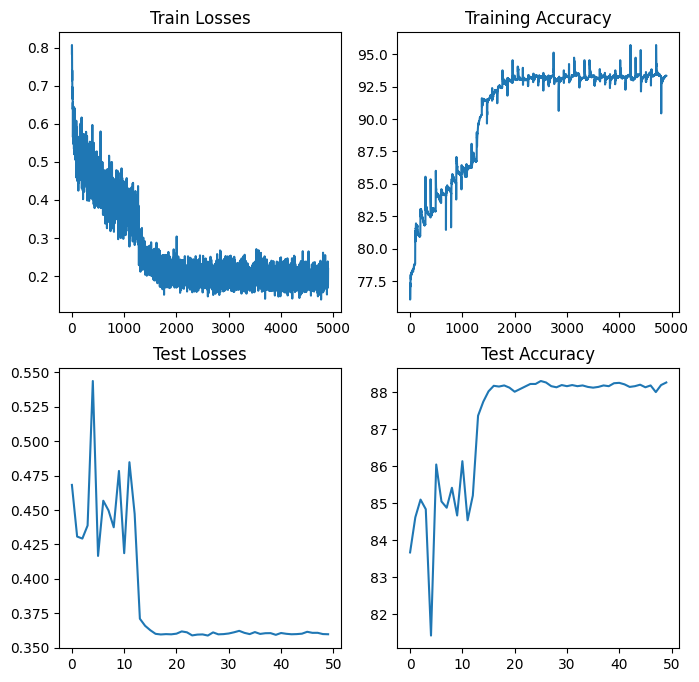

In [49]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)